In [94]:
# import necessary libraries
import pandas as pd 
import numpy as np
import pickle
import torch
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import keras_tuner as kt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf


In [95]:
# load data
path = "datasets/"
test_data_file = "bp_sv_co_test_dataset.pkl"
train_data_file = "bp_sv_co_train_dataset.pkl"

train_data = pickle.load(open(f"{path}{train_data_file}", "rb"))
test_data = pickle.load(open(f"{path}{test_data_file}", "rb"))

In [96]:
# x and Y split
x_train = train_data[0]
y_train = train_data[1]

x_test = test_data[0]
y_test = test_data[1]

In [97]:
# Systolic
y_train_systolic = y_train[:,1]
y_test_systolic = y_test[:,1]

# Diastolic
y_train_diastolic = y_train[:,2]
y_test_diastolic = y_test[:,2]

# SV (systolic volume)
y_train_SV = y_train[:,3]
y_test_SV = y_test[:,3]

In [98]:
y_train.shape, x_train.shape, x_test.shape, y_test.shape

(torch.Size([4005, 5]),
 torch.Size([4005, 3, 100]),
 torch.Size([4045, 3, 100]),
 torch.Size([4045, 5]))

In [67]:
def plot_features(x_train, sample_idx=0):
    """
    Plot the features of a sample.
    """

    # extract the sample from x_train
    sample = x_train[sample_idx]

    sample_dict = {
        "feature_1": sample[0],
        "feature_2": sample[1],
        "feature_3": sample[2],
    }

    sample_df = pd.DataFrame(sample_dict)

    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

    axs[0].plot(sample_df["feature_1"], color='blue')
    axs[0].set_title("Feature 1")
    axs[0].grid(True)

    axs[1].plot(sample_df["feature_2"], color='green')
    axs[1].set_title("Feature 2")
    axs[1].grid(True)

    axs[2].plot(sample_df["feature_3"], color='red')
    axs[2].set_title("Feature 3")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()



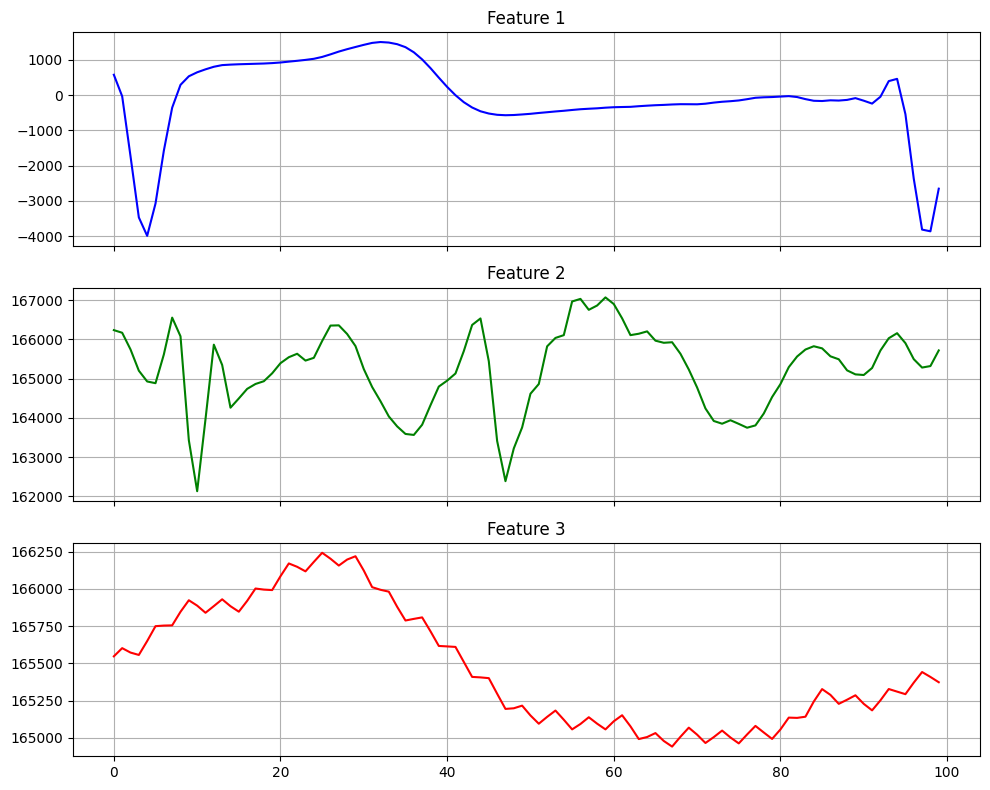

In [68]:
plot_features(x_train)

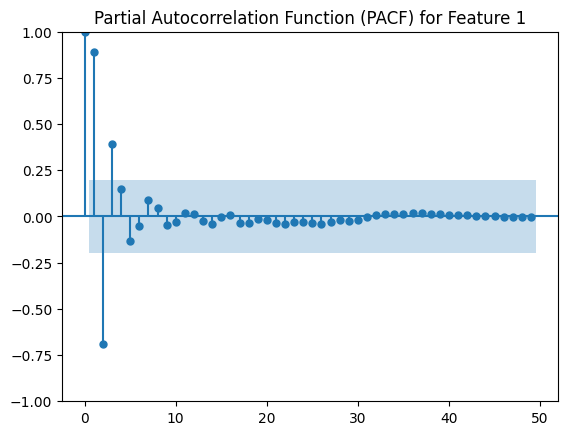

In [69]:
# Plot the Partial Autocorrelation Function (PACF) for one sample of the first feature
plot_pacf(x_train[0][0], lags=49, method='ywm') # one sample of the first feature
plt.title("Partial Autocorrelation Function (PACF) for Feature 1")
plt.show()

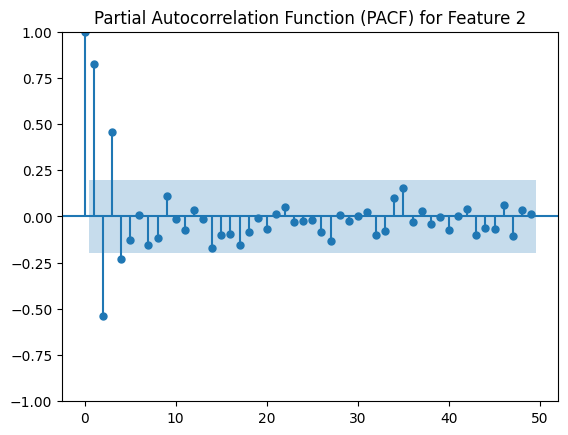

In [70]:
# Plot the Partial Autocorrelation Function (PACF) for one sample of the second feature
plot_pacf(x_train[0][1], lags=49, method='ywm') # one sample of the second feature
plt.title("Partial Autocorrelation Function (PACF) for Feature 2")
plt.show()

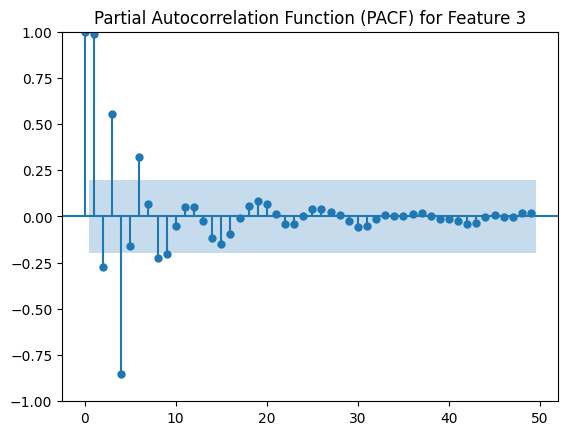

In [71]:
# Plot the Partial Autocorrelation Function (PACF) for one sample of the third feature
plot_pacf(x_train[0][2], lags=49, method='ywm') # one sample of the third feature
plt.title("Partial Autocorrelation Function (PACF) for Feature 3")
plt.show()

In [72]:
# transpose from (samples, features, time steps) to (samples, time steps, features)
x_train = x_train.permute(0, 2, 1).numpy()
x_test = x_test.permute(0, 2, 1).numpy()

In [73]:
# keep only the relevant outputs for y_train and y_test
y_train = y_train[:, 1:3]
y_test = y_test[:, 1:3]

In [74]:
x_train.shape, x_test.shape

((4005, 100, 3), (4045, 100, 3))

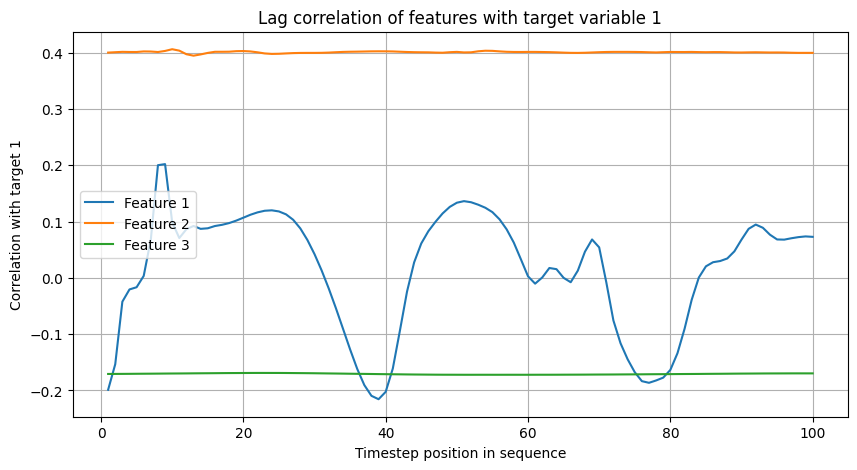

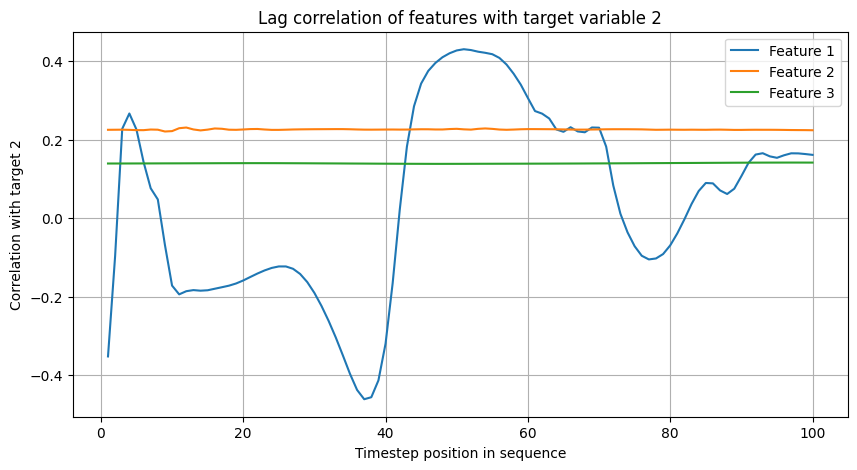

In [75]:
num_samples, timesteps, num_features = x_train.shape
_, num_targets = y_train.shape

for target_idx in range(num_targets):
    plt.figure(figsize=(10, 5))
    for f in range(num_features):
        corrs = []
        for lag in range(timesteps):
            values_at_lag = x_train[:, lag, f]
            target_values = y_train[:, target_idx]
            corr = np.corrcoef(values_at_lag, target_values)[0, 1]
            corrs.append(corr)
        
        plt.plot(range(1, timesteps + 1), corrs, label=f'Feature {f+1}')
    
    plt.xlabel('Timestep position in sequence')
    plt.ylabel(f'Correlation with target {target_idx+1}')
    plt.title(f'Lag correlation of features with target variable {target_idx+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [76]:
y_test

tensor([[109.0283,  46.9890],
        [106.5572,  46.6270],
        [105.3833,  47.7937],
        ...,
        [120.4249,  69.1176],
        [125.4908,  69.3416],
        [123.7914,  64.6130]])

In [77]:
y_train.shape, y_test.shape

(torch.Size([4005, 2]), torch.Size([4045, 2]))

In [78]:
# reshape to (samples*timesteps, features)
x_train_reshape = x_train.reshape(-1, 3) 
x_test_reshape = x_test.reshape(-1, 3)

# apply MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_train_scaled = scaler_x.fit_transform(x_train_reshape)
x_test_scaled = scaler_x.transform(x_test_reshape)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# get back to original shape
x_train_scaled = x_train_scaled.reshape(x_train.shape)
x_test_scaled = x_test_scaled.reshape(x_test.shape)

In [79]:
x_test_scaled.shape, x_train_scaled.shape, y_test_scaled.shape, y_train_scaled.shape

((4045, 100, 3), (4005, 100, 3), (4045, 2), (4005, 2))

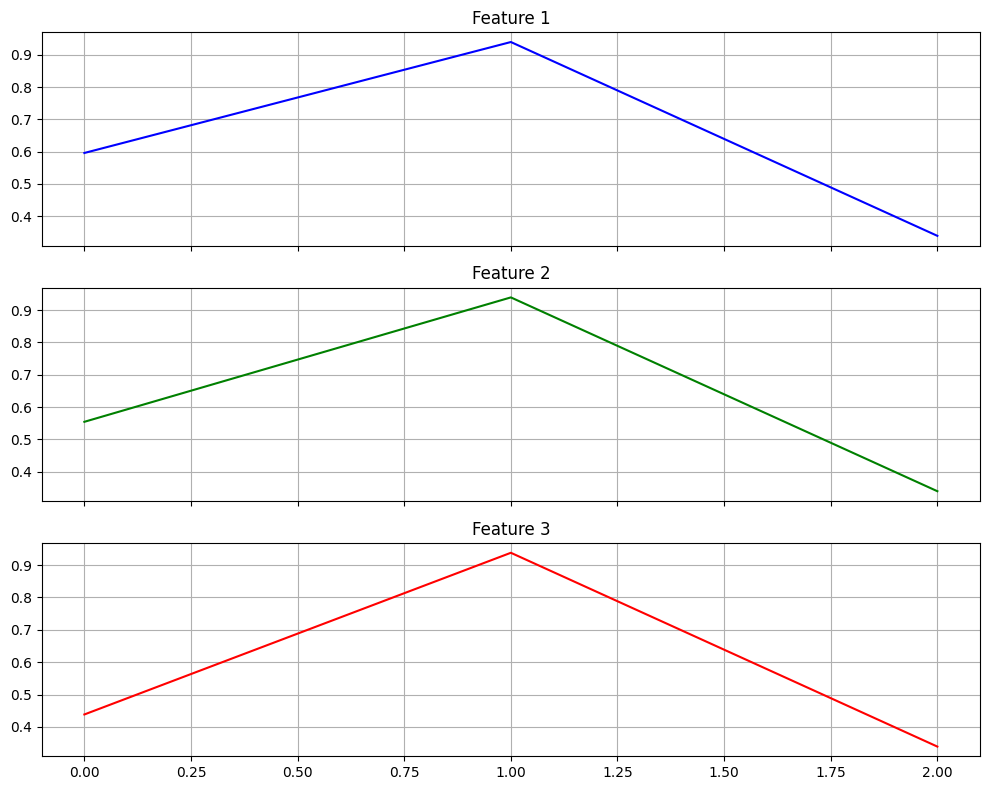

In [80]:
plot_features(x_train_scaled)

In [81]:
# define the model
model = Sequential([
    Input(shape=(100, 3)),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(2)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,386 (118.70 KB)

 Trainable params: 30,386 (118.70 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# early stopping callback
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [83]:
history = model.fit(
    x_train_scaled, y_train_scaled,
    validation_data=(x_test_scaled, y_test_scaled),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0298 - mae: 0.1326 - val_loss: 0.0272 - val_mae: 0.1314
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0181 - mae: 0.1080 - val_loss: 0.0266 - val_mae: 0.1303
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0171 - mae: 0.1052 - val_loss: 0.0275 - val_mae: 0.1368
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0169 - mae: 0.1049 - val_loss: 0.0263 - val_mae: 0.1286
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0163 - mae: 0.1027 - val_loss: 0.0265 - val_mae: 0.1309
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0156 - mae: 0.1004 - val_loss: 0.0279 - val_mae: 0.1322
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0164 - mae: 0.1041 - val_loss: 0.0266 - val_mae: 0.1350
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0151 - mae: 0.0988 - val_loss: 0.0269 - val_mae: 0.1306
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/

In [84]:
loss, mae = model.evaluate(x_test_scaled, y_test_scaled)
print(f'Test Loss: {loss:.4f} - Test MAE: {mae:.4f}')

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0263 - mae: 0.1286
Test Loss: 0.0263 - Test MAE: 0.1286


In [85]:
# make predictions
train_prediction = model.predict(x_train_scaled)
test_prediction = model.predict(x_test_scaled)

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [86]:
# rescale predictions
train_prediction = scaler_y.inverse_transform(train_prediction)
test_prediction = scaler_y.inverse_transform(test_prediction)

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train, train_prediction))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test, test_prediction))
print('Test Score: %.2f RMSE' % (test_score))


Train Score: 12.64 RMSE
Test Score: 16.73 RMSE


In [87]:
def plot_predictions(test_prediction, y_test):
    """
    Plot the features of a sample.
    """

    test_dict = {
        "Systolic": y_test[:, 0],
        "Diastolic": y_test[:, 1],
    }

    prediction_dict = {
        "Systolic": test_prediction[:, 0],
        "Diastolic": test_prediction[:, 1],
    }

    test_df = pd.DataFrame(test_dict)
    prediction_df = pd.DataFrame(prediction_dict)


    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

    axs[0].plot(test_df["Systolic"], color='blue')
    axs[0].plot(prediction_df["Systolic"], color='#1f77b4')
    axs[0].set_title("Systolic")
    axs[0].grid(True)

    axs[1].plot(test_df["Diastolic"], color='green')
    axs[1].plot(prediction_df["Diastolic"], color='#2ca02c')
    axs[1].set_title("Diastolic")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [88]:
test_prediction

array([[129.99077 ,  70.70427 ],
       [130.51198 ,  70.995026],
       [130.76073 ,  71.12914 ],
       ...,
       [126.64748 ,  72.06428 ],
       [126.40466 ,  71.96798 ],
       [125.727615,  71.72163 ]], dtype=float32)

In [89]:
y_test

tensor([[109.0283,  46.9890],
        [106.5572,  46.6270],
        [105.3833,  47.7937],
        ...,
        [120.4249,  69.1176],
        [125.4908,  69.3416],
        [123.7914,  64.6130]])

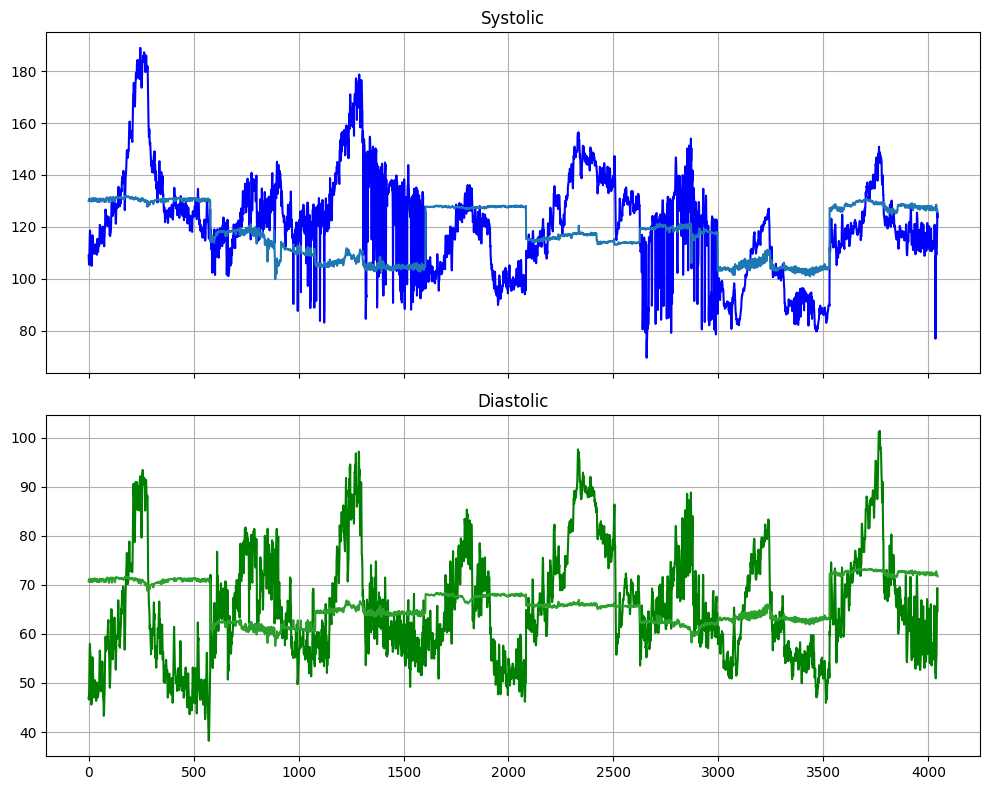

In [90]:
plot_predictions(test_prediction, y_test)

In [91]:
y_train.shape

torch.Size([4005, 2])

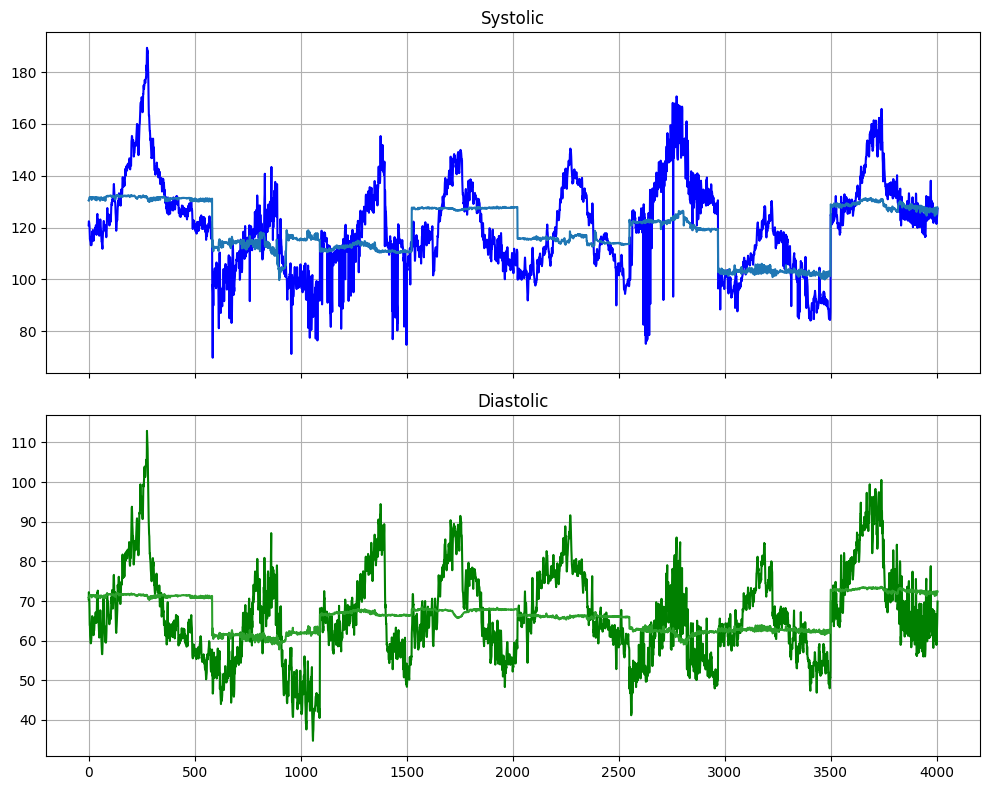

In [92]:
plot_predictions(train_prediction, y_train)

In [ ]:
# build model for hyperparameter tuning
def model_builder(hp):
  """Builds and compiles an LSTM-based regression model for hyperparameter tuning.

    This function creates a Keras Sequential model for time series regression 
    tasks. The architecture includes one or two LSTM layers (tunable), a dense 
    hidden layer, and an output layer for multi-output regression. Several 
    hyperparameters are optimized via Keras Tuner, including:
    
    - Number of LSTM layers (1 or 2)
    - Units in each LSTM layer
    - Units in the dense hidden layer
    - Learning rate for the Adam optimizer

    Args:
        hp (kerastuner.HyperParameters): Hyperparameter search space object 
            used to define tunable parameters such as layer sizes and learning rate.

    Returns:
        keras.Model: A compiled Keras Sequential model ready for training 
            and hyperparameter tuning.
    """
  
  model = keras.Sequential()
  model.add(Input(shape=(100, 3)))

  # tune the number of LSTM layers
  num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=2)
    
  # first LSTM layer
  # Choose an optimal value between 16-512
  units_layer_1 = hp.Int('units_layer_1', min_value=16, max_value=512, step=16)
  model.add(LSTM(units=units_layer_1, activation='tanh', return_sequences=(num_lstm_layers > 1)))
    
  # second LSTM layer (optional)
  if num_lstm_layers > 1:
      # Choose an optimal value between 16-256
      units_layer_2 = hp.Int('units_layer_2', min_value=16, max_value=256, step=16)
      model.add(LSTM(units=units_layer_2, activation='tanh'))

  # Choose an optimal value between 16-128
  units_layer_3 = hp.Int('units_layer_3', min_value=16, max_value=128, step=16)
  model.add(Dense(units=units_layer_3, activation='relu'))
  model.add(Dense(units=2, activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mae'])

  return model

In [ ]:
# initialize the tuner
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss',
                     max_epochs = 100,
                     factor = 10,
                     project_name = 'blood_pressure_estimator')

In [61]:
tuner.search(x_train_scaled, y_train_scaled, epochs=500, callbacks=[early_stop], validation_data=(x_test_scaled, y_test_scaled))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_lstm_layers')}. The optimal number of units in each of the densely-connected
layers is {(best_hps.get('units_layer_1'), best_hps.get('units_layer_2'), best_hps.get('units_layer_3'))} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 3 Complete [00h 00m 14s]
val_loss: 0.02945774793624878

Best val_loss So Far: 0.028232645243406296
Total elapsed time: 00h 00m 31s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
2                 |1                 |num_lstm_layers
352               |272               |units_layer_1
16                |64                |units_layer_3
0.0001            |0.001             |learning_rate
176               |None              |units_layer_2
1                 |1                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

 70/126 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 0.0675 - mae: 0.2081

KeyboardInterrupt: 

In [ ]:
# define the model
model = Sequential([
    Input(shape=(100, 3)),
    LSTM(best_hps.get('units_layer_1'), activation='tanh', return_sequences=True),
    LSTM(best_hps.get('units_layer_2'), activation='tanh'),
    Dense(best_hps.get('units_layer_3'), activation='relu'),
    Dense(3, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100, 400)       │       646,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 192)            │       455,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 112)            │        21,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           339 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,123,779 (4.29 MB)

 Trainable params: 1,123,779 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train_scaled, y_train_scaled,
    validation_data = (x_test_scaled, y_test_scaled),
    epochs = 500,
    batch_size = 16,
    callbacks = [early_stop]
)

Epoch 1/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - loss: 0.0204 - mae: 0.1103 - val_loss: 0.0525 - val_mae: 0.1807
Epoch 2/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - loss: 0.0130 - mae: 0.0888 - val_loss: 0.0471 - val_mae: 0.1585
Epoch 3/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - loss: 0.0115 - mae: 0.0830 - val_loss: 0.0511 - val_mae: 0.1656
Epoch 4/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - loss: 0.0110 - mae: 0.0809 - val_loss: 0.0484 - val_mae: 0.1659
Epoch 5/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - loss: 0.0103 - mae: 0.0778 - val_loss: 0.0443 - val_mae: 0.1571


In [ ]:
loss, mae = model.evaluate(x_test_scaled, y_test_scaled)
print(f'Test Loss: {loss:.4f} - Test MAE: {mae:.4f}')

127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0525 - mae: 0.1807
Test Loss: 0.0525 - Test MAE: 0.1807


In [ ]:
# make predictions
train_prediction = model.predict(x_train_scaled)
test_prediction = model.predict(x_test_scaled)

126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step


In [ ]:
# rescale predictions
train_prediction = scaler_y.inverse_transform(train_prediction)
test_prediction = scaler_y.inverse_transform(test_prediction)

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train, train_prediction))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test, test_prediction))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 10.99 RMSE
Test Score: 18.41 RMSE


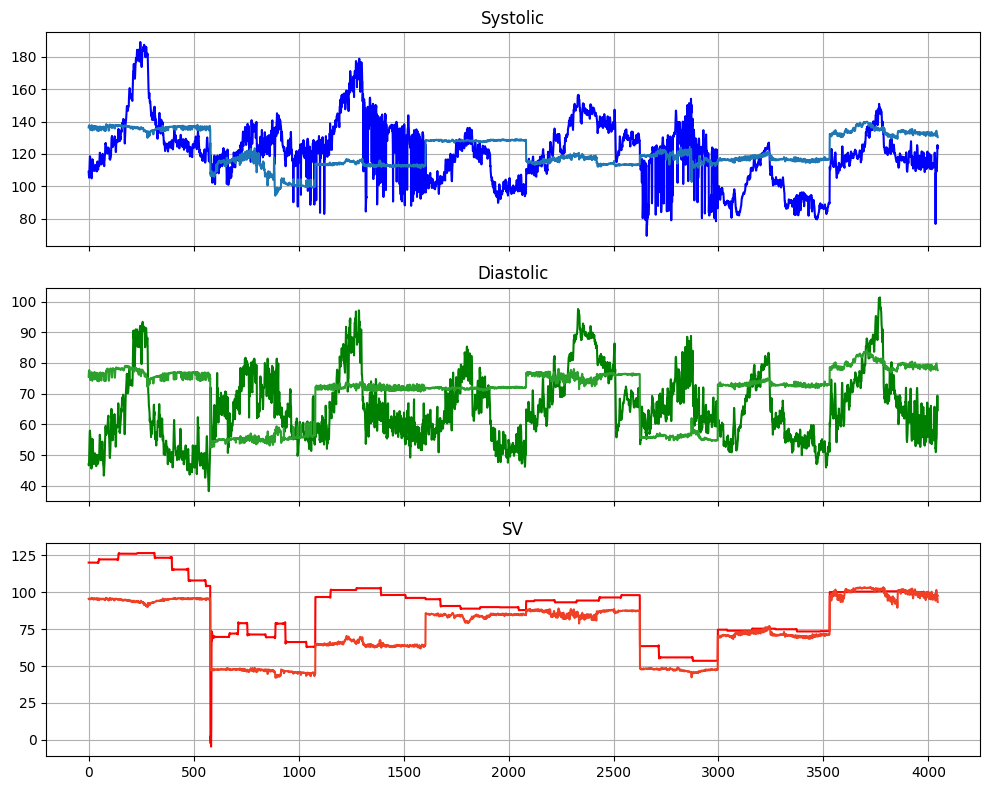

In [ ]:
plot_predictions(test_prediction, y_test)

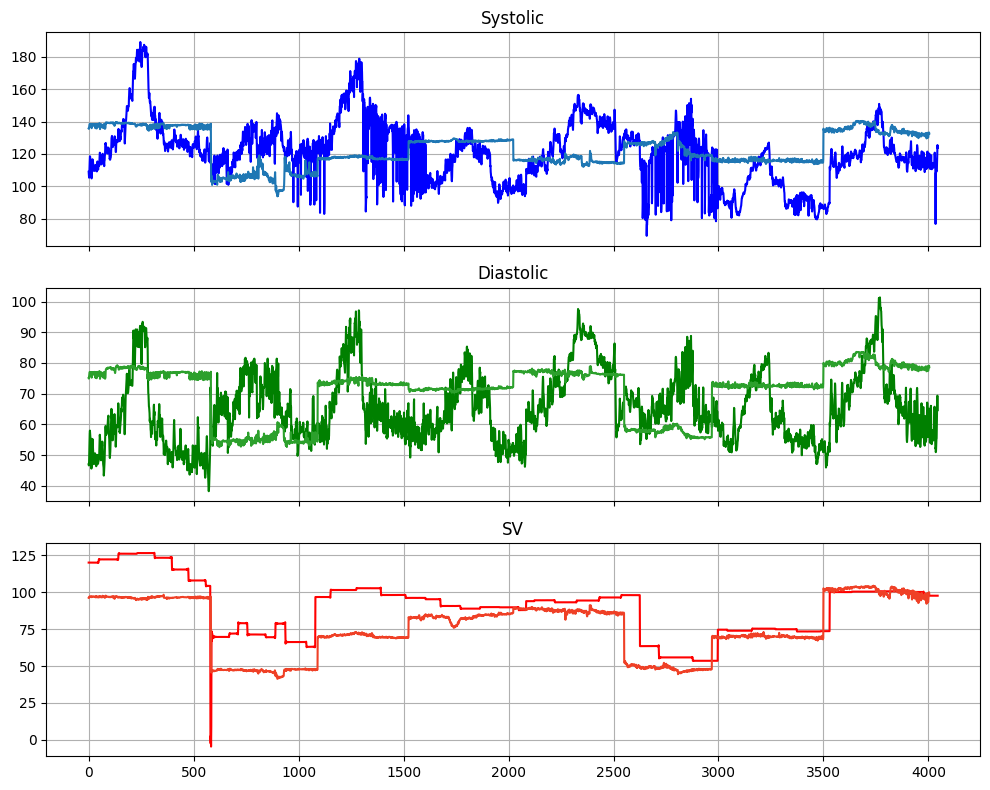

In [ ]:
plot_predictions(train_prediction, y_test)